In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [23]:
data = pd.read_csv('./assets/data.csv', index_col = 'Date')
data = data.iloc[:2665, :]
data

,Open,High,Low,Close,Adj Close,Volume,pct_change,log_change,7ma,14ma,...,S&P500,Japan225,KoreanIndex,NASDQ,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-10,28.030001,28.240000,27.840000,27.990000,21.152483,48591300,-0.000714,-0.000714,28.146893,28.549826,...,1068.13,9963.99,1570.12,2147.87,154.354910,167.290639,174.546314,180.673782,172.971193,171.012076
2010-02-22,28.840000,28.940001,28.650000,28.730000,21.813244,36707100,-0.001390,-0.001391,28.574012,28.565252,...,1108.01,10400.47,1627.10,2242.03,153.927626,166.244162,172.853763,174.978117,155.958916,149.642177
2010-02-23,28.680000,28.830000,28.090000,28.330000,21.509542,52266200,-0.013923,-0.014021,28.513006,28.533674,...,1094.60,10352.10,1628.90,2213.44,153.499577,165.195810,171.157609,169.279583,139.178566,128.763209
2010-02-24,28.520000,28.790001,28.379999,28.629999,21.737309,43165900,0.010589,0.010534,28.542255,28.546592,...,1105.24,10198.83,1612.83,2235.90,153.070772,164.145658,169.458113,163.585385,122.804635,108.716028
2010-02-25,28.270000,28.650000,28.020000,28.600000,21.714539,48735300,-0.001048,-0.001048,28.556692,28.553749,...,1102.94,10101.96,1587.51,2234.22,152.641219,163.093779,167.755537,157.902711,107.004751,89.817016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14,245.580002,249.179993,245.490005,248.149994,241.334167,23901100,0.021067,0.020848,246.390517,248.584560,...,4173.85,28084.47,3153.32,13429.98,206.045819,269.138677,284.117535,262.521311,249.316593,248.136713
2021-05-17,246.550003,246.589996,243.520004,245.179993,238.445740,24970200,-0.011969,-0.012041,246.087886,248.130617,...,4163.29,27824.83,3134.52,13379.05,205.827204,269.009563,284.574358,262.912170,248.306545,247.664162
2021-05-18,246.270004,246.410004,242.899994,243.080002,236.403427,20168000,-0.008565,-0.008602,245.335915,247.457202,...,4127.83,28406.84,3173.05,13303.64,205.606790,268.872795,285.019893,263.271427,247.331329,247.203991


In [24]:
data['y'] = data['Close']


data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

x = data.iloc[:, :53].values
y = data.iloc[:, 53].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split - 20:, :]
train_y, test_y = y[: split, ], y[split - 20: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (2120, 53) trainY: (2120,)
testX: (550, 53) testY: (550,)


In [25]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [26]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([53, 400, 400, 400, 10], 10)

[1/300] Loss: 394.36200046539307
[2/300] Loss: 353.06719398498535
[3/300] Loss: 326.49360275268555
[4/300] Loss: 326.48899841308594
[5/300] Loss: 335.32994842529297
[6/300] Loss: 314.17111110687256
[7/300] Loss: 292.4151439666748
[8/300] Loss: 292.2756357192993
[9/300] Loss: 300.1169786453247
[10/300] Loss: 303.3010187149048
[11/300] Loss: 297.5436143875122
[12/300] Loss: 283.8761987686157
[13/300] Loss: 267.7072582244873
[14/300] Loss: 258.242506980896
[15/300] Loss: 264.49042415618896
[16/300] Loss: 276.4742317199707
[17/300] Loss: 269.44513988494873
[18/300] Loss: 248.90648365020752
[19/300] Loss: 238.02801895141602
[20/300] Loss: 239.38186931610107
[21/300] Loss: 244.41173458099365
[22/300] Loss: 247.31316757202148
[23/300] Loss: 246.08978748321533
[24/300] Loss: 240.6980857849121
[25/300] Loss: 231.89708995819092
[26/300] Loss: 220.85553741455078
[27/300] Loss: 209.70194816589355
[28/300] Loss: 200.95378589630127
[29/300] Loss: 196.83944463729858
[30/300] Loss: 197.6436996459961
[

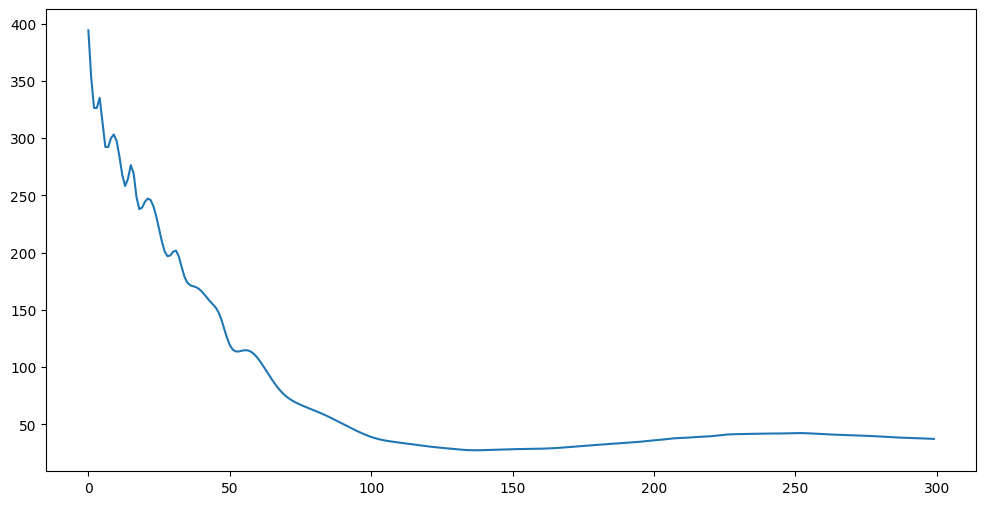

In [27]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [28]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [29]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [30]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [31]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([2117, 3, 63]) train_y: torch.Size([2117, 1]) train_y_gan: torch.Size([2117, 4, 1])
test_x: torch.Size([547, 3, 63]) test_y: torch.Size([547, 1]) test_y_gan: torch.Size([547, 4, 1])


In [32]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out_6 = self.linear_3(out_5)
        return out_6

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 5, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.linear2 = nn.Linear(220, 220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out = self.linear3(out_2)
        return out

In [33]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000115
num_epochs = 100
critic_iterations = 5
weight_clip = 0.01

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(63).to(device)
modelD = Discriminator().to(device)

optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        critic_real = modelD(y)
        critic_fake = modelD(fake_data)
        lossD = -(torch.mean(critic_real) - torch.mean(critic_fake))
        modelD.zero_grad()
        lossD.backward(retain_graph = True)
        optimizerD.step()

        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()

        loss_D.append(lossD.item())
        loss_G.append(lossG.item())
    histG[epoch] = sum(loss_G)
    histD[epoch] = sum(loss_D)
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


[1/100] LossD: -0.0014760238118469715 LossG:-0.06010296754539013
[2/100] LossD: -0.0033879573456943035 LossG:-0.09318158542737365
[3/100] LossD: -0.005129222292453051 LossG:-0.12829300062730908
[4/100] LossD: -0.006939026527106762 LossG:-0.14708387199789286
[5/100] LossD: -0.007960927672684193 LossG:-0.1633719438686967
[6/100] LossD: -0.007380405440926552 LossG:-0.18118082825094461
[7/100] LossD: -0.005345812998712063 LossG:-0.19015902373939753
[8/100] LossD: -0.00255021546036005 LossG:-0.1938022654503584
[9/100] LossD: -0.0001954706385731697 LossG:-0.18999516870826483
[10/100] LossD: 0.0008599022403359413 LossG:-0.1819714494049549
[11/100] LossD: 0.0005571814253926277 LossG:-0.1778159849345684
[12/100] LossD: -0.00020206905901432037 LossG:-0.17301793303340673
[13/100] LossD: -0.000830063596367836 LossG:-0.17152755055576563
[14/100] LossD: -0.001257285475730896 LossG:-0.16184712667018175
[15/100] LossD: -0.0017015431076288223 LossG:-0.15966004692018032
[16/100] LossD: -0.00204082764685

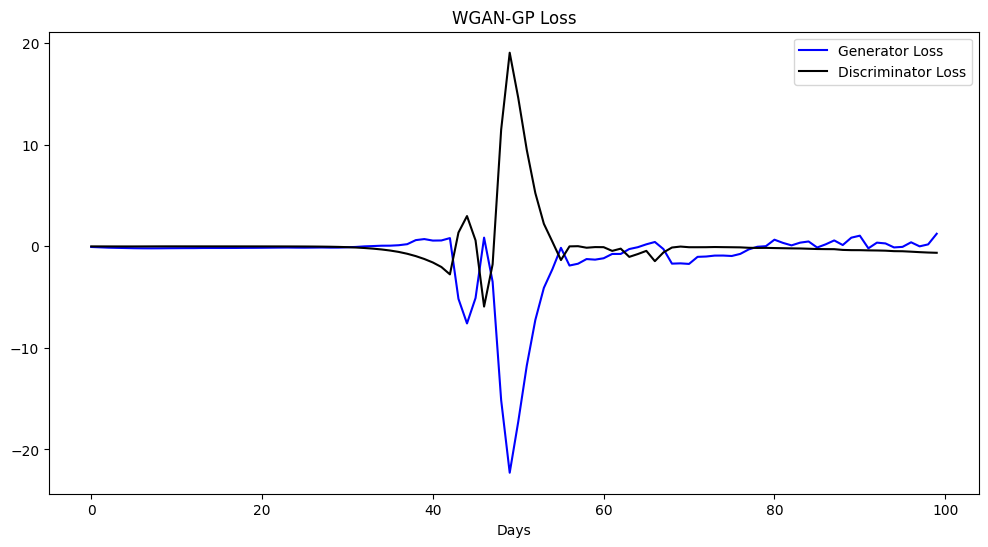

In [34]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('WGAN-GP Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [35]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:5.107569050299606


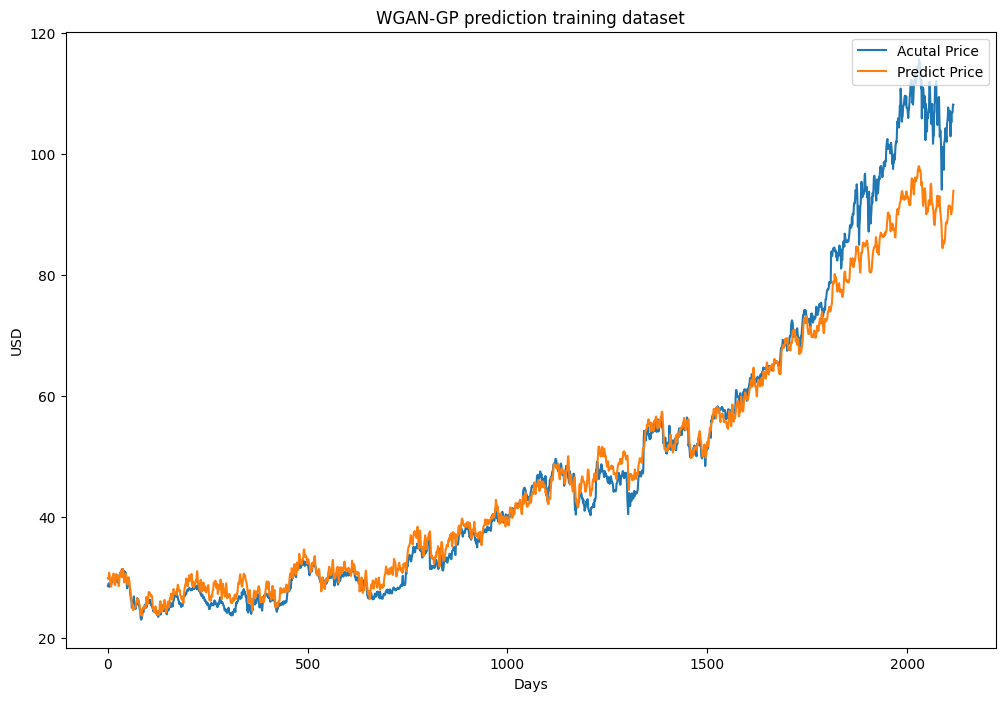

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true,  label = 'Acutal Price')
plt.plot(y_train_pred,  label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('USD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:50.28589837140786


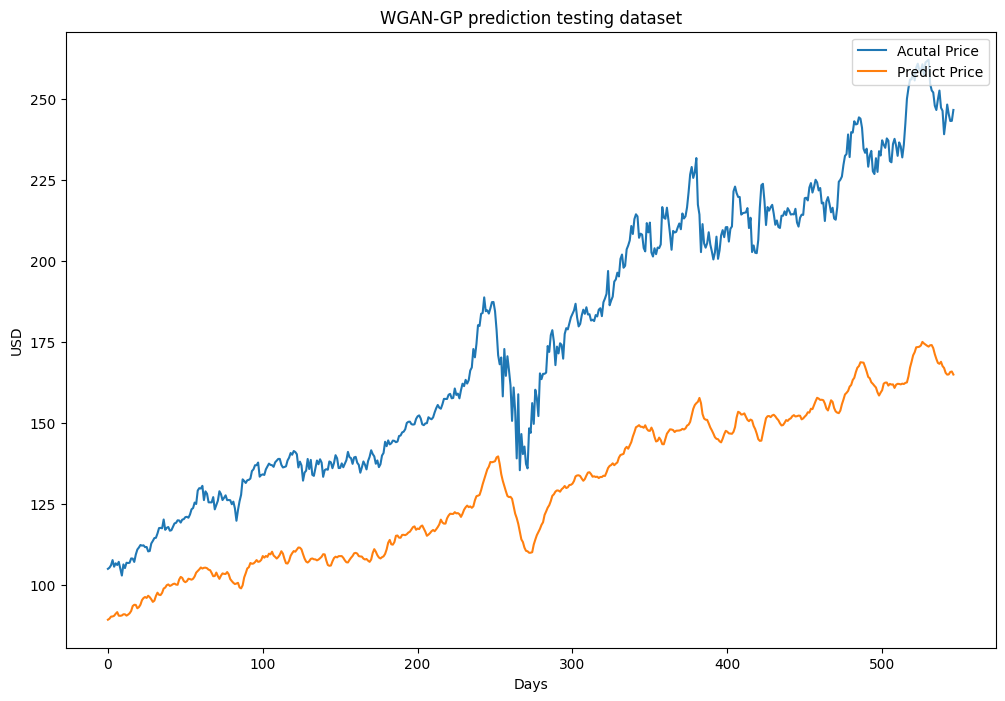

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true,  label = 'Acutal Price')
plt.plot(y_test_pred,  label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('USD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')